# MSc. AI
## Capstone Project
### Darragh Minogue

### 1. Background


This project adopts the facility location problem to the school network in Ethiopia to expand access to secondary education. Of the 40,776 schools in the country, 37,039 offer primary education, but only 3,737 offer secondary. On average, primary schools are located more than 7km away from the nearest secondary school, meaning children face long journeys or they don't access secondary at all.

The expansion of secondary education is a major priority for the Ministry of Education, Ethiopia. Ambitious five year targets are set in the Education Sector Development Plans (ESDP). In 2013/2014, the Gross Enrollment Rate (GER) for lower secondary was 38.9% (3,466,972/8,914,837 children) and a target of 74% (6,596,979/8,914,837 children) was set. However, by 2019/2020, the actual GER was 51.05% (4,551,024/8,914,837 children), a more modest increase of 12.15% rather than 35.1%.  In the latest five year ESDP (2020/2021-2024/2025), an increase of 24% was set, but under the key-performance indicator of 'Number of newly established secondary schools', it says TBD- for 'To Be Determined'. Therein lies part of the problem: planning. Often, a portion of the budget is allocated for secondary, then each region decides how and where to spend it. Planners then, at the macro level, identify primary schools with the highest demand (i.e. largest enrollment) and seek to construct schools to serve that particular school population. While this can often yeild good results, the goal of this project is to improve on this approach in a way that allows for the potential construction of secondary schools across a catchment of multiple primary schools, if enrollment is sufficient and distance is minimal. Meta-heuristic optimisation techniques are used to achieve this.

The project makes use of readily available data from the Ministry of Education, Ethiopia, mainly 1) enrollment data from the Education Managament Information System (EMIS) and 2) geolocation data, recently obtained from the World Bank in 2020. Since national population and census data is inaccurate and outdated in Ethiopia, this was not considered a reliable source for this project. Instead, it is assumed that primary schools are located within the community and new secondary schools should therefore be constructed close to existing primary schools.

### 2. The Problem

In the problem, there is a list of existing primary schools and secondary schools in Ethiopia, their enrollment and location data (region, zone, district, longitude and latitude). The aim is to expand the secondary school network by constructing new secondary schools that best serve the demand from the existing primary school network. No limit is placed on capacity as this is determined by budget which is not known in advance and subject to change (**TO BE CONFIRMED**). Key to solving the problem is understanding that when a school is located within a village, there is no impact of distance on enrolment nor dropout. However, beyond the aspirational norm of 1-2km, distance affects initial access to school but also creates barriers to retention, completion and transition to higher level. As such, the aim is to minimise distance, but construct schools in locations with the highest demand.

### 3. Approach

<b> Glossary of terms</b>
* PS: Primary Schools
* SS: Secondary Schools
* EE: Expected Enrollment
* EEI: Expected Enrollment Increase
* Feeder: a primary school that is part of the secondary school catchment area.
* x: proposed new secondary schools (the genotype).
* d: distance in km between primary schools and 
* proposed_schools: the total number of schools proposed for construction.

This solution proposes new SS locations that can provide the highest estimated enrollment from feeder PS whilst also ensuring they are constructed within at minimal distance. Given the multitude of different languages and the decentralised Government of Ethiopia, models are developed at a regional level.

Two different algorithms are used in this project to find an optimal solution: Random Search, and CMA-ES (**description to follow**). In each of the algorithms, the objective function f() aims to <b> maximise overall expected enrollment </b> given a set of feasible locations: x. Feasibility of the locations or the genotype, x, is controlled using a box boundary of longitudes and latitudes for a given region. Initial starting points are also provided within the box boundary using a generate_random_sp() helper function. 

The fitness is determined using an expected_enrollment function. This takes in the parameters: 1) the location of existing PS, 2) the enrollment of existing PS, 3) x, and 4) the current distance between existing PS and existing SS. The function then calculates the haversine distance in kilometers (km) between each new SS in x and all PS within a given region. This vector, <b> d </b>, is of size: (proposed_schools, len(ps)). Using this data, the algorithm then addresses three key challenges:

1) **The need to identify the PS with the minimal distance to the new SS**. In this case, if a PS is close to two or more new SS, only the closest is selected. But if the PS is closer to an existing SS, then it's ignored as it's already a feeder school to the existing SS.

2) **The need to estimate the expected enrollment of the new SS, based on the distance to its feeder PS**. If a school is beyond a certain threshold distance in km, then the PS should not be considered a feeder school for a SS. To handle this, situation, a helper function is used to estimate the expected enrollment from a feeder PS to the nearby SS. It takes in as parameters a) distance to nearest SS and b) PS enrollment. It then makes some assumptions about distance to return the expected enrollment per school. Theunynck (2014) recommends the adoptation of a norm of 2 or 3km for junior secondary schools and the function therefore assumes that if a school is constructed within 2km of a PS, there is no negative effect on expected enrollment of it's nearby SS. Above 2km, a linear dropoff is assumed between 2-5km. If a PS is located more than 5km away from the new location proposed, it is expected that zero students will attend from that feeder school.

3) **The need to divert expected enrollment from a PS if it is currently a feeder school to an existing SS but the new SS proposed is closer**. This is dealt with by subtracting the expected enrollment from the PS to the existing SS using the shape function, and then allocating it to the new SS which is closer. 

A fitness evaluation budget of 10,000 is set to ensure there are sufficient iterations to achieve convergance. Each algorithm is run 30 times with different random starting points. The results are stored in a csv file, with the top 4 results plotted below. 

### Assumptions and Limitations

1. It is assumed that 1km is equivalent to a 15 minute walk for children (Theunynck, S. 2014: p6).
2. Distance is calculated using the haversine function and as a result distance is calculated as a straight line. The travel distances could therefore be further. Ethiopia is not well mapped and since most children are walking to school using other means like Google Maps API don't yeild useful results on a large scale and don't factor in more informal walking routes. Final results require close inspection for elevation and other issues that might impact walking distance or construction e.g. buildings, rivers. The final results should therefore be observed as an approximation and using a tool like ArcGIS or QGIS, the the results are observed for these types of obstacles. 
3. It is assumed that children beyond 5km are not likely to attend, but in some cases, this is not true. Some children walk extremely long distances to attend secondary school, while others stay with relatives or family friends to attend a school that is beyond 5km. Despite this being a reality, this shouldn't guide the construction as the goal is to minimise distance and create more equitable access to secondary. 

In [2]:
# Key Imports
import pandas as pd
import numpy as np
from haversine import haversine, haversine_vector, Unit
import geopandas as gpd
import matplotlib.pyplot as plt
import cma
import time

# Supress the scientific notation on numpy for easierx reading.
np.set_printoptions(suppress=True)

In [9]:
# Specify which test to perform: 1) basic test with 2 schools, 2) basic test with 1 district, 3) regional test.
declare_test = 3 

In [10]:
# Declare key variables according to the test being performed.
region = 'Amhara' # Test Amhara region
woreda = 'ET030908' # for testing of one woreda/district in Amhara.

if declare_test == 1: # for micro test
    # read in the prepared dataset. Evaluate point data to make it readible by geopandas
    df = pd.read_csv('data/test_dataset2.csv', converters={'point': pd.eval})
    proposed_schools= 2
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
elif declare_test == 2: # district or woreda test.
    df = pd.read_csv('data/test_dataset.csv', converters={'point': pd.eval})
    proposed_schools= 5
    gdf_woreda = gpd.read_file('eth_shape_files/json/eth_admin3v2.json')
    gdf_woreda_shp = gdf_woreda.loc[gdf_woreda['ADM3_PCODE']==woreda]['geometry'].reset_index(drop=True)
    df = df.loc[df['ADM3_PCODE'] == woreda]
    bounds = gdf_woreda_shp.bounds
else: # for regional test
    proposed_schools= 5
    df = pd.read_csv('data/clean_dataset.csv', converters={'point': pd.eval})
    # limit geojson to only selected region
    # limit clean dataset to only selected region
    gdf_region = gpd.read_file('eth_shape_files/json//eth_admin1v2.json') # read in geojson
    gdf_region_shp = gdf_region.loc[gdf_region['ADM1_EN']==region]['geometry'].reset_index(drop=True)
    df = df.loc[df['region'] == region]
    bounds = gdf_region_shp.bounds 

In [11]:
df.head(5)

,region,zone,woreda,school_name,school_code,geometry,lat,lon,gr_offer,urban_rural,...,ADM3_PCODE,ADM0_EN,ADM1_EN,ADM2_EN,ADM3_EN,point,nearest_up_prim,nearest_sch_code,nearest_lwr_sec,nearest_up_sec
0,Amhara,Misrak Gojjam,Hulet_Ej_Ene,Tekort,S0306020712,POINT (37.9873 11.0999),11.099900,37.98730,G.1-4,1,...,ET030602,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[11.0999, 37.9873]",0.015579,S0306021802,NaN,NaN
1,Amhara,Misrak Gojjam,Hulet_Ej_Ene,Boda Kidanemihiret,S0306021792,POINT (37.69205 11.05947),11.059470,37.69205,G.1-4,1,...,ET030602,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[11.05947, 37.69205]",2.090068,S0306020482,NaN,NaN
2,Amhara,Misrak Gojjam,Hulet_Ej_Ene,Meklit,S0306020332,POINT (37.79732 11.077843),11.077843,37.79732,G.1-8,1,...,ET030602,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[11.077843, 37.79732]",NaN,S0306180503,8.653923,NaN
3,Amhara,Misrak Gojjam,Sedie,Grarema,S0306020292,POINT (37.9104 10.7492),10.749200,37.91040,G.1-8,1,...,ET030602,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[10.7492, 37.9104]",NaN,S0306012833,13.340141,NaN
4,Amhara,Misrak Gojjam,Sedie,Jema,S0306025422,POINT (37.8078 10.88),10.880000,37.80780,G.1-8,1,...,ET030602,Ethiopia,Amhara,East Gojam,Hulet Ej Enese,"[10.88, 37.8078]",NaN,S0306025393,1.156893,NaN


In [12]:
df.columns

Index(['region', 'zone', 'woreda', 'school_name', 'school_code', 'geometry',
       'lat', 'lon', 'gr_offer', 'urban_rural', 'grade7', 'grade8', 'grade7_8',
       'grade1_4', 'grade1_4_f', 'grade1_4_m', 'grade5_8', 'grade5_8_f',
       'grade5_8_m', 'grade9_10', 'grade9_10_f', 'grade9_10_m', 'grade11_12',
       'grade11_12_f', 'grade11_12_m', 'water_y_n', 'has_separate_toilet',
       'has_toilet', 'ADM0_PCODE', 'ADM1_PCODE', 'ADM2_PCODE', 'ADM3_PCODE',
       'ADM0_EN', 'ADM1_EN', 'ADM2_EN', 'ADM3_EN', 'point', 'nearest_up_prim',
       'nearest_sch_code', 'nearest_lwr_sec', 'nearest_up_sec'],
      dtype='object')

In [13]:
# Establish boundaries based on the bounds of region or woreda.
# Latitude is the Y axis, longitude is the X axis.

lat_bounds = bounds[['miny','maxy']].to_numpy(dtype=float)[0]
lon_bounds = bounds[['minx','maxx']].to_numpy(dtype=float)[0]
bounds = np.array([[lat_bounds[0], lon_bounds[0]], [lat_bounds[1], lon_bounds[1]]])
# array - [[lower lat bounds, lower lon bounds],[upper lat bounds, upper lon bounds]]
# CMA expects a list of size 2 for bounds
x1y1 = np.repeat([bounds[0,:]],proposed_schools, axis=0).flatten()
x2y2 = np.repeat([bounds[1,:]],proposed_schools, axis=0).flatten()
boundsxy = [x1y1,x2y2]
boundsxy

[array([ 8.71481253, 35.26108445,  8.71481253, 35.26108445,  8.71481253,
        35.26108445,  8.71481253, 35.26108445,  8.71481253, 35.26108445]),
 array([13.76296565, 40.21243796, 13.76296565, 40.21243796, 13.76296565,
        40.21243796, 13.76296565, 40.21243796, 13.76296565, 40.21243796])]

In [14]:
# Create subset arrays required as input for enrollment function.
# 1. Primary school enrollment data. Only the last two grades as predictors for the two grades of lower secondary.
# 2. Primary school location data: lat lon point data. 
# 3. Secondary schoool location data: lat lon point data. 
# 4. Secondary school enrollment data. Only grades 9 and 10 enrollment. 

df_prim = df.loc[df['grade7_8'] > 0]
df_prim_enroll = df_prim['grade7_8'].reset_index(drop=True).to_numpy(dtype=float)
df_prim_loc = df_prim['point'].reset_index(drop=True).to_numpy()
df_prim_loc = np.array([np.array(i) for i in df_prim_loc], dtype=float)

df_sec = df.loc[ (df['gr_offer'] == 'G. 9-10') | (df['gr_offer'] == 'G. 9-12')]
df_sec_loc = df_sec['point'].reset_index(drop=True).to_numpy()
df_sec_enroll = df_sec['grade9_10'].reset_index(drop=True).to_numpy(dtype=float)
df_sec_loc = np.array([np.array(i) for i in df_sec_loc], dtype=float)

current_ps_distance = df_prim['nearest_lwr_sec'].to_numpy() # existing distance to secondary school

## Helper Functions

In [15]:
# Function to shape expected enrollment. 
def shape(distance, enrollment):
    # If less than 2km, all children expected to attend secondary i.e. distance not a factor
    min_walk = 2 
    max_walk = 5 # distance greater than 5km (1hr 15 mins) assumes school too far, and zero enrollment expected.
    # if between 2-5km, return a linear dropoff.
    return np.rint(np.where(distance<min_walk, enrollment,
             np.where(distance>max_walk, 0,
                     enrollment*(1-(distance-min_walk)/(max_walk-min_walk)))
            ))

# Example below
shape(3, 1000)

667.0

In [8]:
# Function to generate random starting points for each proposed school within box boundary.
def generate_random_sp():
    sp1 = np.random.uniform(low=lat_bounds[0], high=lat_bounds[1], size=proposed_schools)
    sp2 = np.random.uniform(low=lon_bounds[0], high=lon_bounds[1], size=proposed_schools)
    sp = np.vstack((sp1, sp2)).T
    return sp

generate_random_sp() 

array([[10.10012156, 35.36385271],
       [11.80091482, 36.09359296],
       [ 9.06274743, 37.35905863],
       [13.06339897, 38.28328694],
       [ 9.37142355, 38.32756078]])

In [10]:
# Helper for fitness function to take in a vector of primary schools and the distance, and return jagged array.
def get_close_schools(ps, current_ds):    
    # Gets (index and distance) of schools located less than 5km and less than current distance.
    return [[i, ps[i]] for i in range(len(ps)) if ((ps[i] < 5) & (ps[i] < current_ds[i]))]

## Fitness Function

In [11]:
# Constant
ee_old_constant = np.sum(df_sec_enroll) # existing enrollment for secondary

def expected_enrollment(prim_loc, x, prim_enroll, current_dist):
    ee_old  = ee_old_constant.copy() # copy of current overall secondary enrollment
    feeder = {} # empty dictionary for list of ps, closest ss and distance in km.
    eei = 0 # expected enrollment increase
    d = haversine_vector(prim_loc, x, Unit.KILOMETERS, comb=True) # distance of PS to x. 
    # keep only those < 5 and < current_dist
    closest = [get_close_schools(d[i], current_dist) for i in range(proposed_schools)] 
    
    for ss in range(proposed_schools):
        for ps in range(len(closest[ss])): # for each PS distance to every proposed secondary school.
            closest_prim = closest[ss][ps] # [0] == school index, [1] == distance to nearest new secondary.
            if closest_prim[0] not in feeder: # if not in feeder, add to feeder dict.
                feeder[closest_prim[0]] = [ss, closest_prim[1]] 
            
            elif (closest_prim[1] < feeder[closest_prim[0]][1]): # if another SS is closer, replace in feeder 
                feeder[closest_prim[0]] = [ss, closest_prim[1]]
            
            # Current estimated enrollment feeding into current SS
            distance_current = shape(current_dist[closest_prim[0]], prim_enroll[closest_prim[0]])
            ee_old -= distance_current # remove old secondary students within catchment.
        
    # eei is only the final schools being added.
    closest_ss_dist = np.array([row[1] for row in list(feeder.values())])
    ps_enroll = prim_enroll[list(feeder.keys())]
    eei = np.sum(shape(closest_ss_dist, ps_enroll))
    return eei + ee_old # for overall expected enrollment. 

## Objective Function

In [12]:
# The Objective Function with the shape function included.
def f(x):
    x = x.reshape(proposed_schools,2) #  add new schools to existing and reshape
    test_case = expected_enrollment(df_prim_loc, x, df_prim_enroll, current_ps_distance)
    return test_case*-1 # Multiply by -1 for maximising.

In [13]:
# example result of objecitve function.
f(generate_random_sp())

-434696.0

# 1. Establish Benchmark

To establish a baseline, the traditional method planners used for identifying potential locations is followed. This involves identifying all the PS above a certain threshold to the nearest SS. For this project, 5km is deemed the ultimate cut-off. Secondly, the data is filtered to only the number of schools being proposed e.g. 5. It is then assumed that these locations are best to construct the new school as demand is highest. 

This project aims to test this theory and find improvements. 

In [16]:
dd = df_prim[df_prim['nearest_lwr_sec'] >5] # Find all PS > 5km distance
dd = dd.sort_values(['grade7_8'], ascending=False).head(proposed_schools) # filter by number of SS to construct i.e. 5.
benchmark = sum(dd['grade7_8']) # sum the enrollment for a basic indication of expected enrollment
benchmark

4286

Above displays the overall enrollment from only the number of proposed schools. However, there is also a need to test these locations using the objective function. Why? In many cases, schools with high enrollment are located in more urban locations which may be close by to many other primary schools that could benefit from a new SS being built nearby the proposed schools. The objective function will provide a wider estimate than only the schools with the top enrollment. 

In [17]:
benchmark_loc = dd['point'].reset_index(drop=True).to_numpy()
benchmark_loc = np.array([np.array(i) for i in benchmark_loc], dtype=float)
benchmark_f = f(benchmark_loc)

-440997.0

In [20]:
# Below are the figures to beat.
print('Overall expected enrollment: ', benchmark_f, '\n' \
      'Expected Enrollment Increase: ', round(abs(np.sum(df_sec_enroll) - abs(benchmark_f)),0))

Overall expected enrollment:  -440997.0 
Expected Enrollment Increase:  6373.0


## 2. Random Search

In [21]:
# Random Search Algorothm is used to see if an improved solution can be identified.
def random_search(f, n):
    x = [generate_random_sp() for _ in range(n)]
    fx = [[f(xi), xi] for xi in x]
    best_f, best_solution = min(fx, key=lambda x:x[0])
    return best_f, best_solution

In [29]:
n_starting_points = 30
maxits = 10000

In [22]:
%%time
# Run the algorithm 10,000 times by 30 different starting points.
fx = []
for _ in range(n_starting_points):
    start_time = time.time()
    fx.append([random_search(f, maxits), time.time() - start_time])
    print(_,time.time() - start_time, 'starting point completed.')

0 118.72786211967468 starting point completed.
1 121.49694967269897 starting point completed.
2 128.6024248600006 starting point completed.
3 124.1004147529602 starting point completed.
4 95.300368309021 starting point completed.
5 85.5407178401947 starting point completed.
6 88.92698907852173 starting point completed.
7 88.67874360084534 starting point completed.
8 87.93585848808289 starting point completed.
9 88.18937540054321 starting point completed.
10 87.8680191040039 starting point completed.
11 88.59263348579407 starting point completed.
12 88.39424967765808 starting point completed.
13 88.12962055206299 starting point completed.
14 88.70426607131958 starting point completed.
15 88.23384213447571 starting point completed.
16 88.26836800575256 starting point completed.
17 88.57155203819275 starting point completed.
18 88.66025233268738 starting point completed.
19 89.89638018608093 starting point completed.
20 89.18017411231995 starting point completed.
21 89.02343487739563 star

In [23]:
results = pd.DataFrame(columns=['random_starting_point', 'algorithm', 'ee', 'eei', 'proposed_locations', 'time', 'sigma'])

In [24]:
for i in range(0, len(fx)):
    row = (pd.Series({'random_starting_point':i, 'algorithm':'Random Search', 'ee':round(abs(fx[i][0][0]),0),
                                'eei':round(abs(np.sum(df_sec_enroll) - abs(fx[i][0][0])),0), 
                                'proposed_locations': fx[i][0][1], 'time':fx[i][1], 'sigma':'NA'}))
    results = results.append(row, ignore_index=True)

In [25]:
results

,random_starting_point,algorithm,ee,eei,proposed_locations,time,sigma
0,0,Random Search,437552.0,2928.0,"[[10.683850182474766, 37.69771646812091], [11....",118.727862,NA
1,1,Random Search,437778.0,3154.0,"[[10.158362108735153, 38.13410647666529], [11....",121.496950,NA
2,2,Random Search,438445.0,3821.0,"[[10.170691898005266, 37.95234133000432], [11....",128.602425,NA
3,3,Random Search,437197.0,2573.0,"[[11.828710881048567, 37.59955073893839], [10....",124.100415,NA
4,4,Random Search,437252.0,2628.0,"[[12.832339666778939, 36.65528489994976], [10....",95.300368,NA
5,5,Random Search,437304.0,2680.0,"[[13.484853838233, 38.1490727395683], [13.4381...",85.540718,NA
6,6,Random Search,437539.0,2915.0,"[[12.203097068181197, 36.288777743856535], [11...",88.926989,NA
7,7,Random Search,437513.0,2889.0,"[[12.13449228244409, 38.05564964677766], [11.7...",88.678744,NA
8,8,Random Search,438481.0,3857.0,"[[11.835056581173934, 35.406797652061215], [11...",87.935858,NA
9,9,Random Search,437538.0,2914.0,"[[12.12890682537877, 38.0584875759422], [13.33...",88.189375,NA


Random Search does not find an improved solution. 

# 3. CMA

In [26]:
results = results.reset_index(drop=True)

In [35]:
sigmas = (0.05, 0.1, 0.15, 0.2, 0.24)

In [36]:
%%time
fcma = []

for i in range(n_starting_points):
    start_time = time.time()
    for j in sigmas:
        es = cma.CMAEvolutionStrategy(generate_random_sp().flatten(), sigma0=j,
                                  inopts={'bounds': boundsxy,'seed':1234})
        es.optimize(f, iterations=maxits / es.popsize)
        fcma.append((es.result[1], es.result[0].reshape(proposed_schools, 2), (time.time() - start_time), j))

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 11:17:35 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.352300000000000e+05 1.0e+00 4.39e-02  4e-02  4e-02 0:00.1
    2     20 -4.352870000000000e+05 1.2e+00 4.02e-02  4e-02  4e-02 0:00.2
    3     30 -4.353380000000000e+05 1.2e+00 3.96e-02  4e-02  4e-02 0:00.3
   37    370 -4.361900000000000e+05 2.6e+00 7.49e-03  4e-03  8e-03 0:03.3
   81    810 -4.362200000000000e+05 8.6e+00 1.31e-03  4e-04  2e-03 0:07.3
  100   1000 -4.362210000000000e+05 1.1e+01 6.25e-04  2e-04  8e-04 0:09.1
  166   1660 -4.362230000000000e+05 2.2e+01 3.93e-04  9e-05  5e-04 0:15.1
  200   2000 -4.362230000000000e+05 3.4e+01 1.90e-04  3e-05  2e-04 0:18.4
  220   2200 -4.362230000000000e+05 4.2e+01 1.39e-04  2e-05  2e-04 0:20.2
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 11:17:56 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     

    2     20 -4.352040000000000e+05 1.2e+00 2.14e-01  2e-01  2e-01 0:00.2
    3     30 -4.354070000000000e+05 1.2e+00 2.10e-01  2e-01  2e-01 0:00.3
   32    320 -4.355140000000000e+05 2.7e+00 1.19e-01  7e-02  1e-01 0:03.4
   73    730 -4.359360000000000e+05 5.5e+00 1.19e-01  5e-02  1e-01 0:07.5
  100   1000 -4.364900000000000e+05 5.9e+00 7.39e-02  3e-02  9e-02 0:10.4
  161   1610 -4.373470000000000e+05 5.2e+00 1.59e-02  5e-03  2e-02 0:16.4
  200   2000 -4.374530000000000e+05 6.3e+00 3.51e-03  6e-04  3e-03 0:20.2
  283   2830 -4.374590000000000e+05 1.0e+01 1.62e-04  2e-05  1e-04 0:28.2
  295   2950 -4.374590000000000e+05 9.2e+00 1.04e-04  1e-05  7e-05 0:29.4
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 11:22:19 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.352960000000000e+05 1.0e+00 4.96e-02  5e-02  5e-02 0:00.1
    2     20 -4.358510000000000e+05 1.3e+00 4.73e-02  4e-02  5e-02 0:00.2
    3     30 -4.35702000

  284   2840 -4.370830000000000e+05 1.9e+01 2.10e-04  2e-05  2e-04 0:27.2
  293   2930 -4.370830000000000e+05 2.0e+01 1.24e-04  8e-06  9e-05 0:28.1
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 11:26:15 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.357250000000000e+05 1.0e+00 2.28e-01  2e-01  2e-01 0:00.1
    2     20 -4.350610000000000e+05 1.2e+00 2.35e-01  2e-01  2e-01 0:00.2
    3     30 -4.352790000000000e+05 1.3e+00 2.41e-01  2e-01  3e-01 0:00.3
   35    350 -4.361190000000000e+05 2.5e+00 1.69e-01  1e-01  2e-01 0:03.3
   78    780 -4.371030000000000e+05 4.1e+00 3.43e-02  2e-02  4e-02 0:07.4
  100   1000 -4.373960000000000e+05 6.2e+00 1.80e-02  5e-03  2e-02 0:09.4
  164   1640 -4.374740000000000e+05 1.8e+01 1.10e-03  2e-04  2e-03 0:15.5
  200   2000 -4.374750000000000e+05 2.2e+01 3.76e-04  4e-05  5e-04 0:18.9
  262   2620 -4.374760000000000e+05 5.8e+01 2.39e-04  8e-06  4e-04 0:24.8
(5_w,10)-aCMA-ES (mu_w=3

   78    780 -4.356890000000000e+05 6.1e+00 2.19e-01  1e-01  4e-01 0:07.5
  100   1000 -4.355090000000000e+05 6.9e+00 1.71e-01  8e-02  3e-01 0:09.7
  161   1610 -4.374050000000000e+05 1.1e+01 6.93e-02  1e-02  1e-01 0:15.8
  200   2000 -4.380390000000000e+05 1.7e+01 8.72e-03  1e-03  1e-02 0:19.7
  280   2800 -4.380630000000000e+05 3.1e+01 3.19e-04  2e-05  4e-04 0:27.7
  300   3000 -4.380640000000000e+05 3.2e+01 1.27e-04  7e-06  2e-04 0:29.7
  311   3110 -4.380640000000000e+05 3.2e+01 1.04e-04  6e-06  1e-04 0:30.8
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 11:30:34 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.351150000000000e+05 1.0e+00 2.15e-01  2e-01  2e-01 0:00.1
    2     20 -4.349890000000000e+05 1.1e+00 2.16e-01  2e-01  2e-01 0:00.2
    3     30 -4.352750000000000e+05 1.2e+00 2.18e-01  2e-01  2e-01 0:00.3
   34    340 -4.357180000000000e+05 2.3e+00 1.56e-01  1e-01  2e-01 0:03.3
   75    750 -4.36671000

    1     10 -4.356310000000000e+05 1.0e+00 1.79e-01  2e-01  2e-01 0:00.1
    2     20 -4.353460000000000e+05 1.1e+00 1.69e-01  2e-01  2e-01 0:00.2
    3     30 -4.356840000000000e+05 1.2e+00 1.74e-01  2e-01  2e-01 0:00.3
   34    340 -4.363440000000000e+05 2.5e+00 1.58e-01  1e-01  2e-01 0:03.3
   75    750 -4.362360000000000e+05 4.0e+00 3.66e-02  2e-02  4e-02 0:07.4
  100   1000 -4.366230000000000e+05 5.5e+00 4.04e-02  1e-02  5e-02 0:09.8
  162   1620 -4.368100000000000e+05 1.8e+01 7.75e-03  1e-03  1e-02 0:15.9
  200   2000 -4.368160000000000e+05 2.5e+01 2.26e-03  3e-04  4e-03 0:19.7
  278   2780 -4.368200000000000e+05 8.4e+01 3.03e-04  2e-05  6e-04 0:27.8
  300   3000 -4.368200000000000e+05 8.0e+01 2.25e-04  1e-05  4e-04 0:29.9
  324   3240 -4.368200000000000e+05 7.5e+01 1.67e-04  8e-06  3e-04 0:32.2
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 11:34:55 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.35067000

   75    750 -4.369960000000000e+05 8.3e+00 1.79e-02  5e-03  2e-02 0:07.4
  100   1000 -4.370850000000000e+05 1.3e+01 9.01e-03  1e-03  1e-02 0:09.9
  160   1600 -4.371080000000000e+05 4.5e+01 1.04e-03  9e-05  2e-03 0:15.9
  189   1890 -4.371090000000000e+05 8.3e+01 1.88e-04  1e-05  3e-04 0:18.7
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 11:38:48 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.357940000000000e+05 1.0e+00 1.79e-01  2e-01  2e-01 0:00.1
    2     20 -4.355300000000000e+05 1.1e+00 1.74e-01  2e-01  2e-01 0:00.2
    3     30 -4.356030000000000e+05 1.2e+00 1.69e-01  2e-01  2e-01 0:00.3
   34    340 -4.373090000000000e+05 2.2e+00 1.12e-01  8e-02  1e-01 0:03.4
   75    750 -4.364860000000000e+05 3.9e+00 6.07e-02  3e-02  7e-02 0:07.4
  100   1000 -4.374720000000000e+05 4.6e+00 4.07e-02  1e-02  5e-02 0:09.8
  161   1610 -4.383430000000000e+05 1.0e+01 2.42e-03  5e-04  3e-03 0:15.9
  200   2000 -4.38348000

    1     10 -4.348290000000000e+05 1.0e+00 1.38e-01  1e-01  1e-01 0:00.1
    2     20 -4.349680000000000e+05 1.2e+00 1.40e-01  1e-01  1e-01 0:00.2
    3     30 -4.350990000000000e+05 1.3e+00 1.40e-01  1e-01  1e-01 0:00.3
   33    330 -4.354840000000000e+05 2.6e+00 7.52e-02  5e-02  9e-02 0:03.3
   76    760 -4.356950000000000e+05 7.0e+00 1.88e-02  5e-03  2e-02 0:07.3
  100   1000 -4.357050000000000e+05 1.3e+01 7.73e-03  1e-03  9e-03 0:09.5
  118   1180 -4.357050000000000e+05 1.9e+01 3.25e-03  3e-04  4e-03 0:11.2
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 11:43:03 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.353820000000000e+05 1.0e+00 1.98e-01  2e-01  2e-01 0:00.1
    2     20 -4.359350000000000e+05 1.2e+00 2.10e-01  2e-01  2e-01 0:00.2
    3     30 -4.354510000000000e+05 1.4e+00 2.08e-01  2e-01  2e-01 0:00.3
   36    360 -4.358920000000000e+05 2.4e+00 1.65e-01  1e-01  2e-01 0:03.3
   80    800 -4.35723000

    1     10 -4.352610000000000e+05 1.0e+00 1.33e-01  1e-01  1e-01 0:00.1
    2     20 -4.352790000000000e+05 1.1e+00 1.27e-01  1e-01  1e-01 0:00.2
    3     30 -4.353050000000000e+05 1.2e+00 1.26e-01  1e-01  1e-01 0:00.3
   29    290 -4.356020000000000e+05 2.8e+00 1.05e-01  8e-02  1e-01 0:03.3
   65    650 -4.362260000000000e+05 4.0e+00 3.68e-02  2e-02  4e-02 0:07.4
  100   1000 -4.368920000000000e+05 4.6e+00 1.52e-02  5e-03  2e-02 0:11.3
  156   1560 -4.370770000000000e+05 1.0e+01 1.30e-03  2e-04  1e-03 0:17.3
  200   2000 -4.370760000000000e+05 2.4e+01 9.01e-04  9e-05  1e-03 0:21.8
  274   2740 -4.370790000000000e+05 4.4e+01 1.48e-04  8e-06  2e-04 0:29.8
  286   2860 -4.370790000000000e+05 4.9e+01 8.11e-05  4e-06  8e-05 0:31.2
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 11:47:19 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.356310000000000e+05 1.0e+00 1.79e-01  2e-01  2e-01 0:00.1
    2     20 -4.35346000

   73    730 -4.375880000000000e+05 4.5e+00 9.31e-03  4e-03  1e-02 0:07.5
  100   1000 -4.376410000000000e+05 6.9e+00 1.92e-03  5e-04  2e-03 0:10.3
  159   1590 -4.376450000000000e+05 3.0e+01 2.66e-04  3e-05  3e-04 0:16.3
  200   2000 -4.376460000000000e+05 3.1e+01 1.67e-04  1e-05  2e-04 0:20.5
  279   2790 -4.376460000000000e+05 4.5e+01 8.00e-05  6e-06  9e-05 0:28.6
  285   2850 -4.376460000000000e+05 4.6e+01 6.33e-05  4e-06  7e-05 0:29.2
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 11:51:42 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.352360000000000e+05 1.0e+00 1.48e-01  1e-01  2e-01 0:00.1
    2     20 -4.358670000000000e+05 1.2e+00 1.44e-01  1e-01  1e-01 0:00.2
    3     30 -4.352040000000000e+05 1.2e+00 1.38e-01  1e-01  1e-01 0:00.3
   33    330 -4.364640000000000e+05 2.2e+00 5.27e-02  3e-02  6e-02 0:03.3
   72    720 -4.370180000000000e+05 7.6e+00 1.71e-02  5e-03  2e-02 0:07.4
  100   1000 -4.37085000

    1     10 -4.354390000000000e+05 1.0e+00 9.16e-02  9e-02  9e-02 0:00.1
    2     20 -4.355950000000000e+05 1.2e+00 9.37e-02  9e-02  1e-01 0:00.2
    3     30 -4.355320000000000e+05 1.3e+00 9.40e-02  9e-02  1e-01 0:00.3
   35    350 -4.354410000000000e+05 2.8e+00 1.05e-01  9e-02  1e-01 0:03.3
   78    780 -4.356800000000000e+05 4.2e+00 4.98e-02  3e-02  6e-02 0:07.4
  100   1000 -4.357090000000000e+05 4.5e+00 6.51e-02  3e-02  9e-02 0:09.5
  166   1660 -4.367730000000000e+05 1.1e+01 1.36e-02  2e-03  2e-02 0:15.5
  200   2000 -4.367970000000000e+05 2.0e+01 1.96e-03  2e-04  3e-03 0:18.7
  287   2870 -4.367990000000000e+05 2.8e+01 1.98e-04  2e-05  2e-04 0:26.7
  300   3000 -4.367990000000000e+05 2.7e+01 1.22e-04  1e-05  1e-04 0:27.9
  370   3700 -4.368000000000000e+05 4.9e+01 5.25e-05  2e-06  8e-05 0:34.4
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 11:56:12 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.34829000

  266   2660 -4.365860000000000e+05 7.0e+01 5.61e-05  3e-06  8e-05 0:24.7
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 11:59:48 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.347690000000000e+05 1.0e+00 9.58e-02  9e-02  1e-01 0:00.1
    2     20 -4.350730000000000e+05 1.2e+00 9.58e-02  9e-02  1e-01 0:00.2
    3     30 -4.348250000000000e+05 1.2e+00 1.02e-01  9e-02  1e-01 0:00.3
   36    360 -4.358140000000000e+05 2.7e+00 4.27e-02  3e-02  5e-02 0:03.3
   80    800 -4.363640000000000e+05 7.6e+00 1.08e-02  3e-03  1e-02 0:07.4
  100   1000 -4.364000000000000e+05 1.2e+01 4.70e-03  8e-04  7e-03 0:09.2
  165   1650 -4.364190000000000e+05 4.9e+01 1.08e-03  1e-04  2e-03 0:15.2
  184   1840 -4.364190000000000e+05 7.0e+01 5.14e-04  6e-05  1e-03 0:17.0
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 12:00:05 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     

    2     20 -4.357450000000000e+05 1.1e+00 4.29e-02  4e-02  4e-02 0:00.2
    3     30 -4.359880000000000e+05 1.2e+00 4.04e-02  4e-02  4e-02 0:00.3
   35    350 -4.363700000000000e+05 4.6e+00 1.22e-02  6e-03  2e-02 0:03.3
   78    780 -4.365290000000000e+05 9.6e+00 6.23e-03  1e-03  9e-03 0:07.4
  100   1000 -4.365540000000000e+05 1.3e+01 3.22e-03  5e-04  4e-03 0:09.5
  163   1630 -4.365630000000000e+05 2.4e+01 6.15e-04  5e-05  9e-04 0:15.6
  200   2000 -4.365640000000000e+05 2.7e+01 2.04e-04  1e-05  2e-04 0:19.2
  219   2190 -4.365640000000000e+05 3.6e+01 1.34e-04  7e-06  2e-04 0:21.1
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 12:03:59 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.358100000000000e+05 1.0e+00 9.21e-02  9e-02  9e-02 0:00.1
    2     20 -4.359470000000000e+05 1.2e+00 9.12e-02  9e-02  9e-02 0:00.2
    3     30 -4.359730000000000e+05 1.3e+00 9.21e-02  9e-02  1e-01 0:00.3
   34    340 -4.36425000

    1     10 -4.349540000000000e+05 1.0e+00 4.67e-02  4e-02  5e-02 0:00.1
    2     20 -4.350060000000000e+05 1.2e+00 4.35e-02  4e-02  5e-02 0:00.2
    3     30 -4.350250000000000e+05 1.2e+00 4.18e-02  4e-02  4e-02 0:00.3
   35    350 -4.356030000000000e+05 2.4e+00 2.25e-02  1e-02  2e-02 0:03.3
   79    790 -4.358470000000000e+05 6.4e+00 5.22e-03  1e-03  6e-03 0:07.3
  100   1000 -4.358490000000000e+05 8.4e+00 3.22e-03  6e-04  4e-03 0:09.3
  165   1650 -4.358500000000000e+05 1.3e+01 7.35e-04  1e-04  8e-04 0:15.4
  200   2000 -4.358510000000000e+05 1.9e+01 6.22e-04  6e-05  6e-04 0:18.8
  240   2400 -4.358510000000000e+05 3.4e+01 2.97e-04  2e-05  4e-04 0:22.7
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 12:08:06 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.354390000000000e+05 1.0e+00 9.16e-02  9e-02  9e-02 0:00.1
    2     20 -4.355950000000000e+05 1.2e+00 9.37e-02  9e-02  1e-01 0:00.2
    3     30 -4.35532000

  253   2530 -4.369060000000000e+05 2.9e+01 1.05e-04  8e-06  9e-05 0:23.9
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 12:11:48 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.356630000000000e+05 1.0e+00 4.92e-02  5e-02  5e-02 0:00.1
    2     20 -4.363510000000000e+05 1.2e+00 4.77e-02  4e-02  5e-02 0:00.2
    3     30 -4.362600000000000e+05 1.3e+00 4.42e-02  4e-02  5e-02 0:00.3
   36    360 -4.365700000000000e+05 2.7e+00 7.16e-03  4e-03  8e-03 0:03.3
   80    800 -4.365840000000000e+05 7.8e+00 1.36e-03  3e-04  1e-03 0:07.4
  100   1000 -4.365840000000000e+05 1.4e+01 6.64e-04  1e-04  8e-04 0:09.2
  166   1660 -4.365860000000000e+05 3.0e+01 2.79e-04  2e-05  3e-04 0:15.3
  200   2000 -4.365860000000000e+05 4.8e+01 1.52e-04  1e-05  2e-04 0:18.4
  266   2660 -4.365860000000000e+05 7.0e+01 5.61e-05  3e-06  8e-05 0:24.4
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 12:12:12 2022)
Iterat #

   77    770 -4.365080000000000e+05 3.4e+00 5.90e-02  4e-02  6e-02 0:07.4
  100   1000 -4.368430000000000e+05 3.6e+00 3.70e-02  2e-02  4e-02 0:09.6
  162   1620 -4.382670000000000e+05 6.2e+00 5.86e-03  1e-03  6e-03 0:15.6
  200   2000 -4.383140000000000e+05 7.1e+00 1.05e-03  2e-04  9e-04 0:19.3
  285   2850 -4.383150000000000e+05 1.1e+01 8.61e-05  9e-06  6e-05 0:27.3
  300   3000 -4.383150000000000e+05 1.2e+01 5.29e-05  4e-06  4e-05 0:28.7
  305   3050 -4.383150000000000e+05 1.3e+01 5.55e-05  4e-06  4e-05 0:29.2
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 12:16:02 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.357670000000000e+05 1.0e+00 4.52e-02  4e-02  5e-02 0:00.1
    2     20 -4.357450000000000e+05 1.1e+00 4.29e-02  4e-02  4e-02 0:00.2
    3     30 -4.359880000000000e+05 1.2e+00 4.04e-02  4e-02  4e-02 0:00.3
   36    360 -4.363580000000000e+05 4.6e+00 1.15e-02  6e-03  1e-02 0:03.3
   80    800 -4.36550000

    1     10 -4.350670000000000e+05 1.0e+00 2.26e-01  2e-01  2e-01 0:00.1
    2     20 -4.350870000000000e+05 1.2e+00 2.07e-01  2e-01  2e-01 0:00.2
    3     30 -4.354070000000000e+05 1.3e+00 2.00e-01  2e-01  2e-01 0:00.3
   36    360 -4.367540000000000e+05 2.5e+00 1.47e-01  9e-02  2e-01 0:03.4
   78    780 -4.365220000000000e+05 5.9e+00 6.21e-02  2e-02  8e-02 0:07.4
  100   1000 -4.367030000000000e+05 7.2e+00 3.32e-02  9e-03  4e-02 0:09.5
  163   1630 -4.369260000000000e+05 3.2e+01 1.58e-03  1e-04  3e-03 0:15.6
  200   2000 -4.369290000000000e+05 5.5e+01 4.84e-04  3e-05  9e-04 0:19.2
  267   2670 -4.369290000000000e+05 1.3e+02 1.99e-04  7e-06  4e-04 0:25.4
(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 10 (seed=1234, Sat Jul 16 12:20:04 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 -4.349540000000000e+05 1.0e+00 4.67e-02  4e-02  5e-02 0:00.1
    2     20 -4.350060000000000e+05 1.2e+00 4.35e-02  4e-02  5e-02 0:00.2
    3     30 -4.35025000

In [31]:
for i in range(0, len(fcma)):
    row = (pd.Series({'random_starting_point':i, 'algorithm':'CMA', 'ee':round(abs(fcma[i][0]),0),
                                'eei':round(abs(np.sum(df_sec_enroll) - abs(fcma[i][0])),0), 
                                'proposed_locations': fcma[i][1], 'time':fcma[i][2], 'sigma':fcma[i][3]}))
    results = results.append(row, ignore_index=True)

In [32]:
results = results.sort_values(['eei'], ascending=False).reset_index()

In [33]:
results.to_csv('results4.csv')

In [29]:
from ast import literal_eval

In [44]:
results4 = pd.read_csv('results4.csv', converters={'proposed_locations': literal_eval})

In [45]:
###### Show results of top 4.
top_4 = results4[:4]
top_4

,index,random_starting_point,algorithm,ee,eei,proposed_locations,time,sigma
0,58,28,CMA,439845,5221,"[[12.31926458, 37.22420972], [10.85991884, 38....",198.476289,0.22
1,78,48,CMA,439845,5221,"[[12.31926458, 37.22420972], [10.85991884, 38....",195.298578,0.22
2,188,158,CMA,439845,5221,"[[12.31926458, 37.22420972], [10.85991884, 38....",196.579400,0.22
3,238,208,CMA,439845,5221,"[[12.31926458, 37.22420972], [10.85991884, 38....",198.313439,0.22


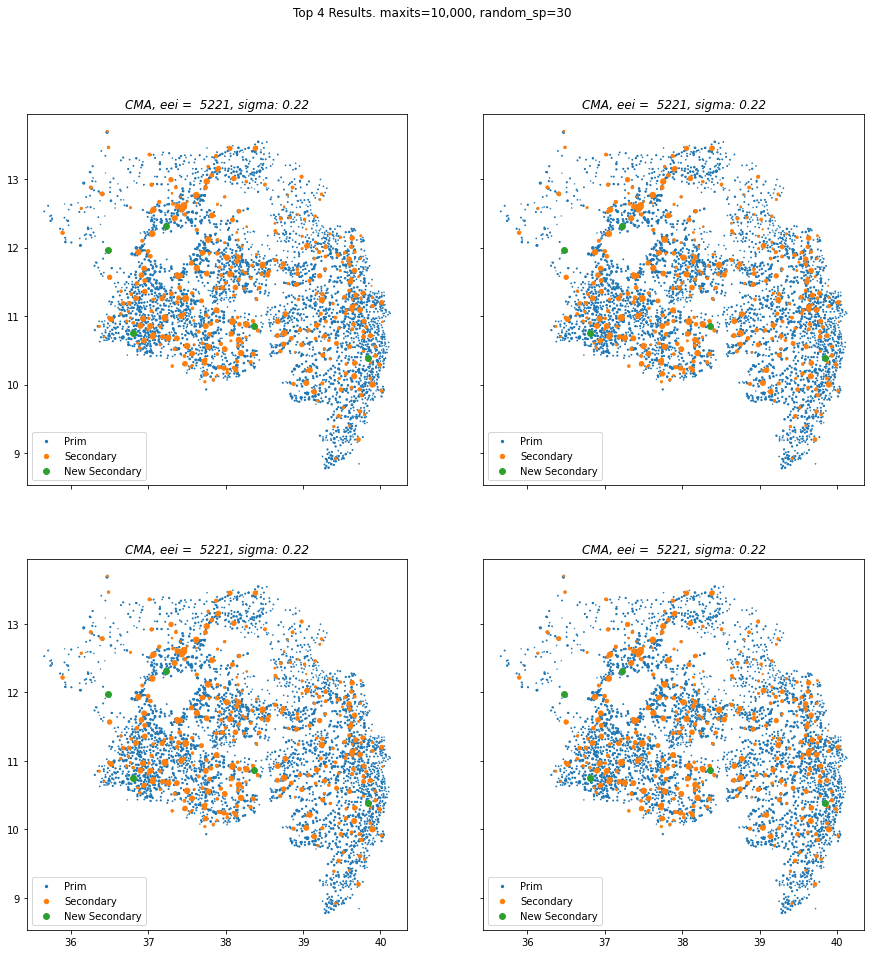

In [75]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(15,15))
fig.suptitle('Top 4 Results. maxits=10,000, random_sp=30')

for i in range(4):
    ax = 'ax'+str(i)
    eval(ax).scatter(df_prim_loc[:, 1], df_prim_loc[:, 0], s=df_prim_enroll/100, label="Prim") # s gives size
    if(len(df_sec) != 0): eval(ax).scatter(df_sec_loc[:, 1], df_sec_loc[:, 0], s=df_sec_enroll/100, label="Secondary") # s gives size
    eval(ax).scatter([row[1] for row in top_4['proposed_locations'][i]], 
                     [row[0] for row in top_4['proposed_locations'][i]], s = 35, \
                      marker="o", label="New Secondary") # stars for supermarkets
#     eval(ax).scatter(top_4['proposed_locations'][i][:,1], top_4['proposed_locations'][i][:,0], s = 35, \
#                      marker="o", label="New Secondary") # stars for supermarkets
    eval(ax).set_title((str(top_4.loc[i]['algorithm']) + ', eei =  ' + str(top_4.loc[i]['eei'])\
                       + ', sigma: ' + str(top_4.loc[i]['sigma'])), fontstyle='italic')

for ax in fig.get_axes():
    ax.legend()
    ax.label_outer()

In [ ]:
# CMA does not beat the benchmark

In [77]:
top_4['ee']

0    439845
1    439845
2    439845
3    439845
Name: ee, dtype: int64

CMA doesn't beat the benchmark. Need to potentially re-run with new parameters